# Анализ поведения пользователей мобильного приложения

# Цели анализа: 

1. Изучить воронку продаж внутри мобильного приложения.
2. Исследовать результаты A/A/B - эксперимента и определить наиболее эффективную группу тестирования

# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная группа.

## 1 Откроем файл с данными и изучим общую информацию

### 1.1 Импортируем необходимые библиотеки. Считаем данные из csv-файла в датафрейм и сохраним в переменную df

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import datetime as dt # импортируем необходимые библиотеки 

In [124]:
df = pd.read_csv('/Users/ilyasidorov/Downloads/logs_exp.csv', sep='\t') # читаем csv-файл

### 1.2 Изучим общую информацию о данных

In [125]:
df.head() # Посмотрим первые строки датафрейма

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [126]:
df.tail() # Посмотрим на последние строки датафрейма 

,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


In [127]:
df.sample(5) # Посмотрим на рандомные выборки из датафрейма

,EventName,DeviceIDHash,EventTimestamp,ExpId
128281,MainScreenAppear,4490608170758380466,1564929411,247
212766,CartScreenAppear,3371640160382097086,1565130443,247
148435,MainScreenAppear,4886271460486563910,1564994145,248
151224,MainScreenAppear,72572501548834659,1564999009,246
205686,CartScreenAppear,1055544042902443290,1565112091,246


In [128]:
df.info() # Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [129]:
df.duplicated().sum() # Наличие дубликатов

413

In [130]:
df.isna().mean()*100 # Наличие пропусков в данных 

EventName         0.0
DeviceIDHash      0.0
EventTimestamp    0.0
ExpId             0.0
dtype: float64

<AxesSubplot:>

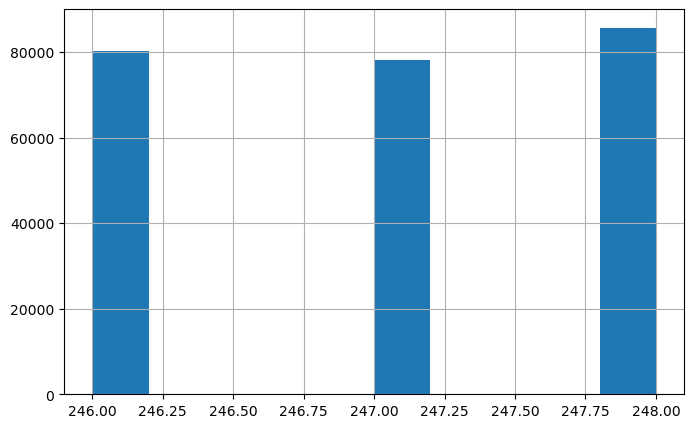

In [131]:
df['ExpId'].hist(figsize=(8, 5)) # Построим гистограмму для столбца ExpId

**Вывод:**  

В таблице:

- 4 столбца
- 244 126 строк 

Пропущенных значений нет. 
Выявлено 413 дубликатов.

## 2 Предобработка данных 

### 2.1 Удалим дубликаты

In [132]:
df = df.drop_duplicates() # Удаляем дубликаты 

In [133]:
df.info() # Проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


### 2.2 Заменим названия столбцов

In [134]:
df.columns=['event_name', 'user_id', 'time_stamp', 'group'] # Замена названий столбцов 
df.head(5) # Проверим новые названия 

,event_name,user_id,time_stamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### 2.3 Заменим значения столбца 'group'

In [135]:
map_group = {246: 'A_1', 247 : 'A_2', 248: 'B'} # Словарь с новыми значениями

In [136]:
df['group'] = df['group'].map(map_group)

### 2.4 Добавим столбцы с датой и временем

In [137]:
df['date_time'] = pd.to_datetime(df['time_stamp'], unit='s')

In [138]:
df['date'] = df['date_time'].dt.date
df

,event_name,user_id,time_stamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,A_1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A_1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A_2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,A_1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,A_1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,A_1,2019-08-07 21:14:58,2019-08-07


In [139]:
df['date'] = df['date'].astype('datetime64')

**Вывод:**

В рамках предобработки данных:

- Удалили 413 дубликатов
- Изменили названия столбцов 
- Добавили новые столбцы с данными о дате и времени
- Поменяли тип данных в столбце с датой
- Переименовали группы

Данные готовы к анализу

## 3 Изучим и проверим данные

### 3.1 Количество событий в логе

In [140]:
df['event_name'].unique() # Посмотрим уникальные значения в столбце event_name

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [141]:
df['event_name'].value_counts() # Посчитаем количество событий каждого уникального значения

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [142]:
event_count = len(df['event_name'])
event_count # Посчитаем сколько всего событий

243713

**Вывод:**

Всего событий в логе - 243 713.

Уникальных событий всего 5: 

- Появление главного экрана (MainScreenAppear - 119101 событий)
- Появление предложения на экране (OffersScreenAppear - 46808 событий) 
- Появление экрана корзины (CartScreenAppear - 42668 событий)
- Подтверждение оплаты (PaymentScreenSuccessful - 34118 событий)
- Инструкция (Tutorial - 1018 событий)

### 3.2 Количество пользователей в логе

In [143]:
users = len(df['user_id'].unique()) # Посчитаем уникальных пользователей 
users

7551

### 3.3 Среднее количество событий на одного пользователя

In [144]:
event_count / users # Разделим количество событий на количество уникальных пользователей 

32.27559263673685

### 3.4 Максимальная и минимальная дата 

In [145]:
max_date = df['date'].max()
min_date = df['date'].min() # Найдем максимальную и минимальную дату

In [146]:
min_date

Timestamp('2019-07-25 00:00:00')

In [147]:
max_date

Timestamp('2019-08-07 00:00:00')

### 3.5 Гистограмма по дате и времени

Text(0.5, 0, 'Дата')

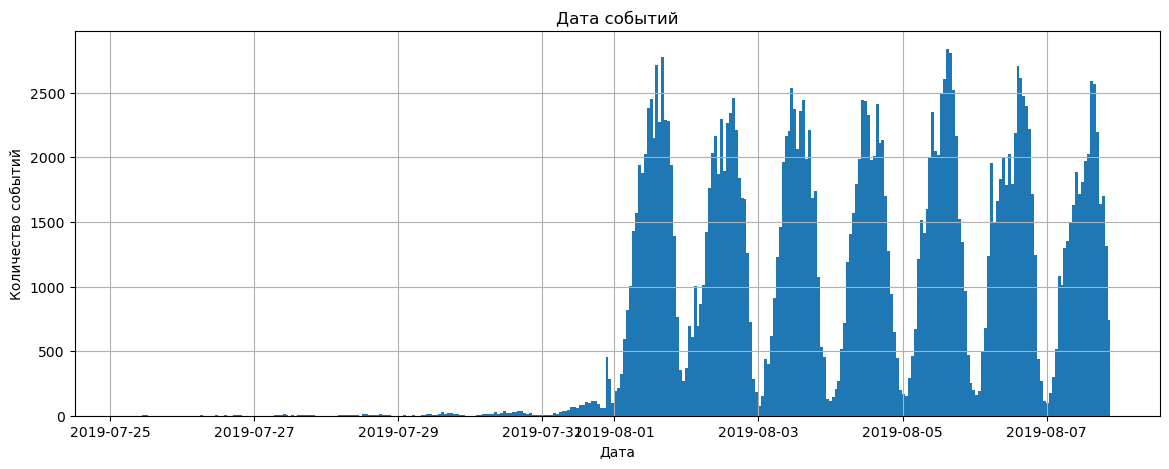

In [149]:
df['date_time'].hist(bins=14*24, figsize=(14, 5))

plt.title('Дата событий')
plt.ylabel('Количество событий')
plt.xlabel('Дата')

**Вывод:**

По гистограмме видно, что основная часть событий происходит в период с 1 августа по 7 августа 2019 года. В первую неделю количество событий крайне низкое (не привышает 5 тысяч)

### 3.6 Отбросим неполные данные

In [150]:
df = df.query('date >= "2019-08-01"') # Сделаем срез и отбросим данные за первую неделю 

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   time_stamp  240887 non-null  int64         
 3   group       240887 non-null  object        
 4   date_time   240887 non-null  datetime64[ns]
 5   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 12.9+ MB


In [152]:
user_after = len(df['user_id'].unique())
user_after # Количество уникальных пользователей после удаления данных 

7534

In [153]:
users_before = users - user_after
users_before # Количество потерянных пользователей после удаления данных

17

In [154]:
share_users = round((users_before / users) * 100, 3) # Доля потерянных пользователей 

In [155]:
event_after = len(df['event_name'])
event_after # Количество событий после удаления данных 

240887

In [156]:
event_before = event_count - event_after
event_before # Количество потерянных событий после удаления данных

2826

In [157]:
share_event = round((event_before / event_count) * 100, 3) # Доля потерянных пользователей 
share_event

1.16

**Вывод:** 

После удаления данных потеряли 2826 событий (1,16% событий) и 17 уникальных пользователей (0,225% пользователей)

После удаления данных:

- 240887 событий 
- 7534 пользователя

### 3.7 Проверим количество событий и пользователей в группах

In [158]:
df.groupby ('group').agg({'user_id': 'nunique', 'event_name': 'count'})

,user_id,event_name
group,,
A_1,2484,79302
A_2,2513,77022
B,2537,84563


**Общий вывод по изучению данных:**

Уникальных событий всего 5.

В среднем на одного пользователя приходится 32 события.

Количество событий и пользователей в группах: 

- В группе 246 - 79302 события и 2484 пользователя
- В группе 247 - 77022 события и 2513 пользователя
- В группу 248 - 84563 события и 2537 пользователя

Определил новый временной период для анализа: c 1 августа по 8 августа 2019 года. Данные за июль исключил из анализа, так как количество событий крайне низкое и удаление данных не должно повлиять на анализ. Потеряли 2826 событий и 17 пользователей

В целом данные в группах примерно равны:

- Cобытий примерно 80 000 в каждой группе
- Количество пользователей примерно 2 500 в каждой группе

## 4 Изучим воронку событий

### 4.1 Посмотрим, какие события есть в логах и как часто они встречаются

In [159]:
event_name_count = (df.groupby('event_name')
                    .agg({'user_id':'count'})
                    .reset_index()
                    .sort_values(by='user_id', ascending=False))
event_name_count

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


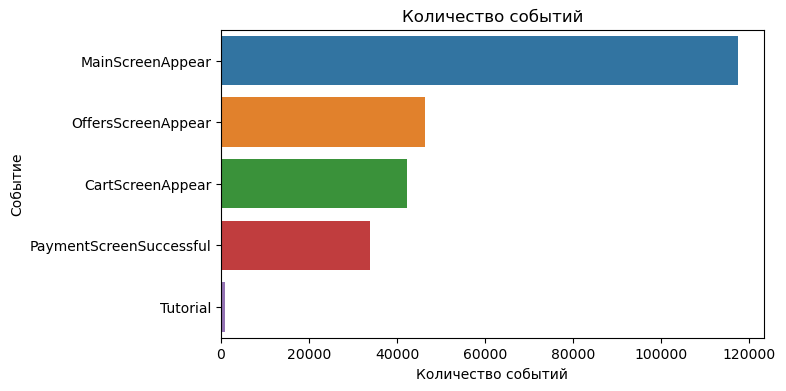

In [160]:
plt.figure(figsize=(7, 4))
plt.title('Количество событий') 
sns.barplot(x='user_id', y='event_name', data = event_name_count)
plt.xlabel('Количество событий')
plt.ylabel('Событие')
plt.show() # Визуализируем данные таблицы event_name_count

**Вывод:**

Практически половина всех событий это - Появление главного экрана (MainScreenAppear).

Менше всего событий - Инструкция (Tutorial)

### 4.2 Посчитаем, сколько пользователей совершали каждое из событий

In [161]:
event_funnel = (df.groupby('event_name')
          .agg({'user_id': 'nunique'})
          .sort_values(by='user_id', ascending=False))
event_funnel # Сколько пользователей совершали каждое событие

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


### 4.3 Посчитаем долю пользователей, которые хоть раз совершали событие

In [162]:
event_funnel['share_users'] = event_funnel['user_id'] / df['user_id'].nunique() * 100
event_funnel # Посчитаем долю пользователей, которые совершали событие

,user_id,share_users
event_name,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719
Tutorial,840,11.149456


**Вывод:**

- Появление главного экрана (MainScreenAppear) посмотрело 98,4% пользователей. 
- Появление предложения на экране (OffersScreenAppear) посмотрело 60,9% пользователей
- Появление экрана корзины (CartScreenAppear) посмотрело 49,5% пользователей
- Подтверждение оплаты (PaymentScreenSuccessful) посмотрело 46,9% пользователей
- Инструкцию (Tutorial) посмотрело 11,1% пользователей

### 4.4 В каком порядке происходят события?

Все события выстраиваются в последовательную цепочку. 

Исключением будет только одно событие - Tutorial (инструкция). Инструкцию посмотрели только 11% пользователей от общего количества. Это событие необходимо исключить из воронки событий, так как просмотр инструкции не является обязательным этапом воронки и не влияет на путь потенциального покупателя.

Цепочка событий:

1. Появление главного экрана (MainScreenAppear)
2. Появление предложения на экране (OffersScreenAppear)
3. Появление экрана корзины (CartScreenAppear)
4. Подтверждение оплаты (PaymentScreenSuccessful)

### 4.5 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [163]:
event_funnel['conversion'] = event_funnel['user_id'] / event_funnel['user_id'].shift() * 100
event_funnel # Считаем долю пользователей, которая проходит на следующий шаг воронки 

,user_id,share_users,conversion
event_name,,,
MainScreenAppear,7419,98.473586,NaN
OffersScreenAppear,4593,60.963632,61.908613
CartScreenAppear,3734,49.561986,81.297627
PaymentScreenSuccessful,3539,46.973719,94.777718
Tutorial,840,11.149456,23.735519


### 4.6 На каком шаге теряется  больше всего пользователей?

Больше всего пользователей теряем после появления главного экрана к появлению предложения на экране- 38,1% пользователей. 

### 4.7 Какая доля пользователей доходит от первого события до оплаты?

In [164]:
round(event_funnel['user_id'][3] / event_funnel['user_id'][0], 3) * 100 

47.699999999999996

**Вывод:**

Воронка продаж следующая:

1. Пользователь видит главный экран (Появление главного экрана (MainScreenAppear))
2. Пользователь видит предложение (Появление предложения на экране (OffersScreenAppear))
3. Пользователь вносит предложение в корзину (Появление экрана корзины (CartScreenAppear))
4. Оплачивает (Подтверждение оплаты (PaymentScreenSuccessful)))

Больше всего пользователей теряем на втором этапе воронки продаж. После просмотра главного экрана 61,9% пользователей переходит на второй этам воронки. 

На третьем и четвертом этапе воронки потери пользователей не значительны. Почти 48% от общего числа пользователей оплачивает покупку в приложении. 

## 5 Изучим результаты эксперимента

### 5.1 Сколько пользователей в каждой группе?

<AxesSubplot:>

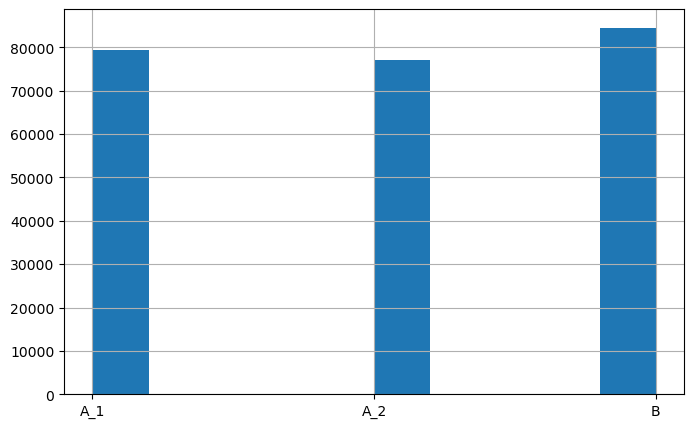

In [165]:
df['group'].hist(figsize=(8, 5)) # Построим гистограмму для столбца group

**Вывод:**

- В группе 246 - 78985 события и 2483 пользователя
- В группе 247 - 76684 события и 2512 пользователя
- В группу 248 - 84213 события и 2535 пользователя

Группы 246 и 247 - контрольные. 
Группа 248 - экспериментальная.

В группах количество пользователей достаточно для проведения исследований. Разница в количестве контрольных и эксперементальных групп незначительна.

### 5.2 С помощью А/А - эксперимента проверим корректность всех механизмов и расчетов. Проверим, находят ли статистические критерии разницу между группами A_1 и A_2

Для A/A - эксперемента создадим таблицы:

- user_count (количество пользователей в каждой группе) 
- test_event_name (количество пользователей, которые проходят по всем событиям кроме Tutorial(Инструкция).

In [166]:
user_count = df.groupby('group')['user_id'].nunique()
user_count['total_A'] = user_count['A_1'] + user_count['A_2']
user_count # Количество пользователей в каждой группе

group
A_1        2484
A_2        2513
B          2537
total_A    4997
Name: user_id, dtype: int64

In [167]:
test_event_name = (df[df['event_name']!='Tutorial'] # Исключим инструкцию из анализа
                   .pivot_table(
                   index='event_name', 
                   columns='group', 
                   values='user_id',
                   aggfunc='nunique')
                   .sort_values(by='A_1', ascending=False))
                   
test_event_name # Количество пользователей по событиям в каждой группе 

group,A_1,A_2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [168]:
test_event_name['total_A'] = test_event_name['A_1'] + test_event_name['A_2']
test_event_name = test_event_name.reset_index()
test_event_name # Соединим количество пользователей в контрольных группах

group,event_name,A_1,A_2,B,total_A
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


**Гипотезы:**

Нулевая гипотеза: доли уникальных посетителей в группах A_1 и A_2, побывавших на этапе воронки, одинаковы.

Альтенативная гипотеза: между долями уникальных посетителей в группах A_1 и A_2, побывавших на этапе воронки, есть значимая разница.

Создадим функцию hypotheses. 

В ней три аргумента:

- Группа №1
- Группа №2 
- Уровень статистической значимости

In [169]:
def hypotheses (group_1, group_2, alpha):
    
    for i in test_event_name.index:
        
        p1 = test_event_name[group_1][i] / user_count[group_1]
        
        p2 = test_event_name[group_2][i] / user_count[group_2]
        
        # пропорция успехов в комбинированном датасете:
        p_combined = ((test_event_name[group_1][i] + test_event_name[group_2][i]) / 
                      (user_count[group_1] + user_count[group_2]))
        
        difference = p1 - p2 # разница пропорций в датасетах
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/user_count[group_1] + 1/user_count[group_2]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-значение: {}'.format(test_event_name['event_name'][i], p_value))
        if (p_value < alpha):
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет')
        print('')

In [170]:
hypotheses ('A_1', 'A_2', 0.01)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет



**Результат A/A теста:**

Между контрольными группами по всем событиям нет статистически значимого различия. Две контрольные группы равны.

Можно приступать к A/B тесту.

### 5.3 Самое популярное событие 

In [171]:
df['event_name'].value_counts() # Посчитаем события 

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

**Вывод:** 

Самое популярное событие - Появление главного экрана (MainScreenAppear)

### 5.4 Число пользователей, которые совершили самое популярное событие из контрольных групп

In [172]:
test_event_name

group,event_name,A_1,A_2,B,total_A
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


**Вывод:**

Число пользователей в контрольных группах, которые совершили самое популярное событие:

- Контрольная группа A1 - 2450 пользователей.
- Контрольная группа A2 - 2476 пользователей.

### 5.5 Посчитаем долю пользователей, которые совершили  самое популярное событие

In [173]:
test_event_name['conversion_A_1'] = round (test_event_name['A_1'] / user_count['A_1'] * 100, 1)
test_event_name['conversion_A_2'] = round (test_event_name['A_2'] / user_count['A_2'] * 100, 1)
test_event_name['conversion_B'] = round (test_event_name['B'] / user_count['B'] * 100, 1)

test_event_name # Конверсия событий в группах

group,event_name,A_1,A_2,B,total_A,conversion_A_1,conversion_A_2,conversion_B
0,MainScreenAppear,2450,2476,2493,4926,98.6,98.5,98.3
1,OffersScreenAppear,1542,1520,1531,3062,62.1,60.5,60.3
2,CartScreenAppear,1266,1238,1230,2504,51.0,49.3,48.5
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.3,46.1,46.6


**Вывод:**

Доля пользователей в группах, которая совершила самое популярное событие:

- Контрольная группа A1 - 98,6% пользователей.
- Контрольная группа A2 - 98,5% пользователей.
- Эксперементальная группа B - 98,3% пользователей.

### 5.6 Сравним результаты эксперементальной группы с каждой из контрольных групп в отдельности по каждому событию

**Гипотезы:**

Нулевая гипотеза: доли уникальных посетителей в группе A_1 и группе B, побывавших на этапе воронки, одинаковы.

Альтенативная гипотеза: между долями уникальных посетителей в группе A_1 и группе B, побывавших на этапе воронки, есть значимая разница.

In [174]:
hypotheses ('A_1', 'B', 0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет



**Вывод:**

Между контрольной группой A_1 и эксперементальной группой B разницы нет 

**Гипотезы:**

Нулевая гипотеза: доли уникальных посетителей в группе A_2 и группе B, побывавших на этапе воронки, одинаковы.

Альтенативная гипотеза: между долями уникальных посетителей в группе A_2 и группе B, побывавших на этапе воронки, есть значимая разница.

In [175]:
hypotheses ('A_2', 'B', 0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет



**Вывод:**

Между контрольной группой A_2 и эксперементальной группой B разницы нет

### 5.7 Сравним результаты эксперементальной группы с объединённой контрольной группой 

**Гипотезы:**

Нулевая гипотеза: доли уникальных посетителей в группе total_A и группе B, побывавших на этапе воронки, одинаковы.

Альтенативная гипотеза: между долями уникальных посетителей в группе total_A и группе B, побывавших на этапе воронки, есть значимая разница.

In [176]:
hypotheses ('total_A', 'B', 0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, оснований считать доли разными нет



**Вывод:**

Между объедененной контрольной группой total_A и эксперементальной группой B разницы нет

**Вывод по проверке гипотез:**

Между контрольными группами и группой с измененным шрифтом разницы нет.

### 5.8 Уровень значимости при проверке статистических гипотез

Для проведения A/A эксперимента был установлен уровень статистической значимости - 0.01. При проведении AA тестов группы должны быть с минимальной разницей. Поэтому уровень разницы был установлен минимальный. 

Для проведения A/B эксперимента был установлен уровень статистической значимости - 0.05. 

### 5.9 Количество проверок статистических гипотез

Было проведено 16 проверок статистических гипотез:

- Между группами A_1 и A_2 - 4 эксперемента по одному на каждое событие.
- Между группами A_1 и B - 4 эксперемента по одному на каждое событие.
- Между группами A_2 и B - 4 эксперемента по одному на каждое событие.
- Между группами total_A и B - 4 эксперемента по одному на каждое событие.

Мы провели множественный тест (множественная проверка гипотез). Осбенность множественного теста, заключается в том, что каждая новая проверка гипотез увеличивает вероятность ошибки первого рода. Для снижения вероятности ложнопозитивного результата при множественной проверке гипотез применяют различные методы корректировки уровня значимости. Часто применяют поправку Бенферрони (делят уровень значимости на количество гипотез). Применять поправку Бонферрони не вижу смысла, так как ни по одному из проведенных сравнений не было обнаружено статистически значемых различий. Изменять уровень статистической значимости нет необходимости. 

## Вывод

В рамках исследования было проанализировано поведение пользователей мобильного приложения, а также была изучена воронка продаж и проанализированы результаты A/A/B - тестов.

**Изучение данных:**

В исходных данных был представлен временной период с 25.07.2019 по 07.08.2019 года. После изучения временного периода было принято решение исключить из анализа первую неделю эксперимента, так как в период с 25 по 31 июля 2019 года количество событий было крайне низкое относительно второй недели эксперимента. Был установлен новый временной период для анализа: c 1 августа по 8 августа 2019 года.

После удаления данных потеряли 2826 событий (1,16% событий) и 17 уникальных пользователей (0,225% пользователей), что вполне допустимо, и существенно не повлияет на результаты анализа.

**После удаления данных:**

- 240887 событий
- 7534 пользователя

Было установлено, что в среднем на одного пользователя приходится 32 события. Уникальных событий всего пять. 

Количество событий и пользователей в группах примерно равны:

В группе A_1 - 79302 события и 2484 пользователя
В группе A_2 - 77022 события и 2513 пользователя
В группу B - 84563 события и 2537 пользователя


**Воронка событий выглядит следующим образом:**

1. Появление главного экрана (MainScreenAppear)
2. Появление предложения на экране (OffersScreenAppear)
3. Появление экрана корзины (CartScreenAppear)
4. Подтверждение оплаты (PaymentScreenSuccessful)

Событие Tutorial (инструкция) было исключено из анализа воронки событи в связи с тем, что просмотр инструкций может происходить на любом этапе воронки и не вписывается в платежную воронку. Инструкцию посмотрели только 11% пользователей от общего количества, что также крайне мало. 

Больше всего пользователей теряем на втором этапе воронки продаж - OffersScreenAppear. После просмотра главного экрана 61,9% пользователей переходит на второй этап воронки. На третьем и четвертом этапе воронки потери пользователей не значительны. 

Почти 48% от общего числа пользователей оплачивает покупку в приложении.

**Анализ результатов A/A/B-теста:**

По результатам A/A/B эспериментов значимой разницы между групп не выявлено. Доли уникальных пользователей, побывавших на этапе воронки, одинаковы. Из этого следует, что изменение шрифта не повлияло на поведение пользователей внутри приложения.

**Рекомендации:**

Анализ конверсии воронки показал, что больше всего пользователей теряем на втором этапе. После просмотра главного экрана 38% пользователей теряется. Пользователи внезапно уходят с приложения не посмотрев предложения. Возможно стоит сделать более удобную навигацию по сайту. Можно также предположить, что в приложении после появления главного экрана выходит ошибка.